In [11]:
from Dataset import Mnist
from Activate_function import ReLULayer, SoftmaxLayer, SigmoidLayer
from Model import FullyConnectedLayer
from Loss_function import CrossEntropyLoss
from Dataloader import DataLoader
from Optimizer import SGD
from Regularization import L2
import numpy as np
import os
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.manifold import TSNE

In [12]:
input_dim = 784
hidden_dim_tot = [128, 256]
output_dim = 10
batch_size = 128
Epoch = 30
lr_tot = [0.1, 0.01]
mini_lr = 0.0001
lam_tot = [0.01, 0.001]
train_rate = 0.8
valid_freq = 5
gamma = 0.99

In [13]:
dataset_root = "../data/mnist"
dataset = Mnist(dataset_root)
train_image, train_label, valid_image, valid_label, test_image, test_label = dataset.load(rate=train_rate)


In [14]:
train_dataloader = DataLoader(data=train_image, label=train_label, batch_size=batch_size)
valid_dataloader = DataLoader(data=valid_image, label=valid_label, batch_size=batch_size)
test_dataloader = DataLoader(data=test_image, label=test_label, batch_size=batch_size)

In [15]:
loss_function = CrossEntropyLoss()

In [16]:
def eval(dataloader, model):
    acc = 0
    tot_number = 0
    loss = 0
    for data, label in dataloader.get_batch():
        data = data.reshape(-1, 28 * 28)
        tot_number += data.shape[0]
        model_forward_result = model.forward(data)
        loss += loss_function.forward(model_forward_result, label)
        prob = SoftmaxLayer().forward(model_forward_result)
        out = np.argmax(prob, axis=1)
        acc += np.sum(out == label)
    return acc / tot_number, loss

In [17]:
class Model():
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.layer1 = FullyConnectedLayer(input_dim, hidden_dim)
        self.layer2 = ReLULayer()
        self.layer3 = FullyConnectedLayer(hidden_dim, output_dim)
        self.layer1.init_parameter()
        self.layer3.init_parameter()
        
    def forward(self, inputs):
        x = self.layer1.forward(inputs)
        x = self.layer2.forward(x)
        x = self.layer3.forward(x)
        return x
    
    def backward(self, Upstream_Gradient):
        gradient = self.layer3.backward(Upstream_Gradient)
        gradient = self.layer2.backward(gradient)
        gradient = self.layer1.backward(gradient)
        return gradient
    
    def get_params(self):
        params1 = self.layer1.get_params()
        params3 = self.layer3.get_params()
        return params1 + params3
    
    def get_grads(self):
        grads1 = self.layer1.get_grads()
        grads3 = self.layer3.get_grads()
        return grads1 + grads3
    
    def save_model(self, name):
        self.layer1.save_model(name=f"{name}_layer1")
        self.layer3.save_model(name=f"{name}_layer3")
    
    def load_model(self, path):
        self.layer1.load_model(path=f"{path}_layer1.npz")
        self.layer3.load_model(path=f"{path}_layer3.npz")
        
    def visualize_params(self, path):
        self.layer1.visualize_params(path=f"{path}/layer1.png")
        self.layer3.visualize_params(path=f"{path}/layer3.png")

In [18]:
def run(hidden_dim, init_lr, lam):
    model = Model(input_dim, hidden_dim, output_dim)
    optimizer = SGD(init_lr)
    regularization = L2(lam)
    best_valid_acc = 0.0
    lr = init_lr
    epoch_loss = []
    epoch_valid_acc = []
    epoch_valid_loss = []
    valid_x = []
    for epoch in range(Epoch):
        batch_num = 0
        loss = 0
        for x_train, y_train in train_dataloader.get_batch():
            x_train = x_train.reshape(-1, 28 * 28)
            model_forward_result = model.forward(x_train)
            loss += loss_function.forward(model_forward_result, y_train)
            # print(f"epoch {epoch}, batch {batch_num}, loss: {loss:.4f}")
            batch_num += 1
            gradient = loss_function.backward()
            gradient = model.backward(gradient)
            # model.step(lr)
            params, grads = model.get_params(), model.get_grads()
            # for i in range(len(params)):
            #     print(f"params[{i}].shape: {params[i].shape}")
            #     print(f"grads[{i}].shape: {grads[i].shape}")
            regularization_grads = regularization.get_grads(model)
            for grad, regularization_grad in zip(grads, regularization_grads):
                grad += regularization_grad
            optimizer.step(params, grads)
            
        lr = lr * gamma
        lr = max(lr, mini_lr)
        optimizer.update_lr(lr)
        
        if (epoch > 0 and epoch % valid_freq == 0):
            valid_x.append(epoch)
            valid_acc, valid_loss = eval(valid_dataloader, model)
            epoch_valid_acc.append(valid_acc)
            epoch_valid_loss.append(valid_loss)
            if (valid_acc > best_valid_acc):
                best_valid_acc = valid_acc
                model.save_model(f"./model_params/Model_hid{hidden_dim}_lr{init_lr}_lambda{lam}")
        print(f"epoch {epoch}, loss: {loss:.4f}, best_valid_acc: {best_valid_acc: .4f}")
        epoch_loss.append(loss)

    return best_valid_acc, epoch_loss, epoch_valid_acc, epoch_valid_loss, valid_x

In [19]:
best_valid_acc = 0
best_hidden_dim, best_lr, best_lam = 0, 0, 0
epoch_loss_tot = []
epoch_valid_acc_tot = []
epoch_valid_loss_tot = []
label_tot = []
valid_x = None
for hidden_dim in hidden_dim_tot:
    for lr in lr_tot:
        for lam in lam_tot:
            valid_acc, epoch_loss, epoch_valid_acc, epoch_valid_loss, valid_x = run(hidden_dim, lr, lam)
            label = f"hid{hidden_dim}_lr{lr}_lambda{lam}"
            label_tot.append(label)
            epoch_loss_tot.append(epoch_loss)
            epoch_valid_acc_tot.append(epoch_valid_acc)
            epoch_valid_loss_tot.append(epoch_valid_loss)
            if (valid_acc > best_valid_acc):
                best_valid_acc = valid_acc
                best_hidden_dim, best_lr, best_lam = hidden_dim, lr, lam
print(f"best valid acc: {best_valid_acc:.4f}, hidden_dim: {hidden_dim}, lr: {best_lr}, lambda: {best_lam}")

epoch 0, loss: 1843.7196, best_valid_acc:  0.0000
epoch 1, loss: 154.3463, best_valid_acc:  0.0000
epoch 2, loss: 127.7213, best_valid_acc:  0.0000
epoch 3, loss: 140.5555, best_valid_acc:  0.0000
epoch 4, loss: 146.6511, best_valid_acc:  0.0000
epoch 5, loss: 148.5042, best_valid_acc:  0.9092
epoch 6, loss: 148.9115, best_valid_acc:  0.9092
epoch 7, loss: 148.7561, best_valid_acc:  0.9092
epoch 8, loss: 148.3889, best_valid_acc:  0.9092
epoch 9, loss: 147.9640, best_valid_acc:  0.9092
epoch 10, loss: 147.5387, best_valid_acc:  0.9093
epoch 11, loss: 147.1350, best_valid_acc:  0.9093
epoch 12, loss: 146.7273, best_valid_acc:  0.9093
epoch 13, loss: 146.3554, best_valid_acc:  0.9093
epoch 14, loss: 146.0162, best_valid_acc:  0.9093
epoch 15, loss: 145.7091, best_valid_acc:  0.9119
epoch 16, loss: 145.4293, best_valid_acc:  0.9119
epoch 17, loss: 145.1710, best_valid_acc:  0.9119
epoch 18, loss: 144.9320, best_valid_acc:  0.9119
epoch 19, loss: 144.7048, best_valid_acc:  0.9119
epoch 20,

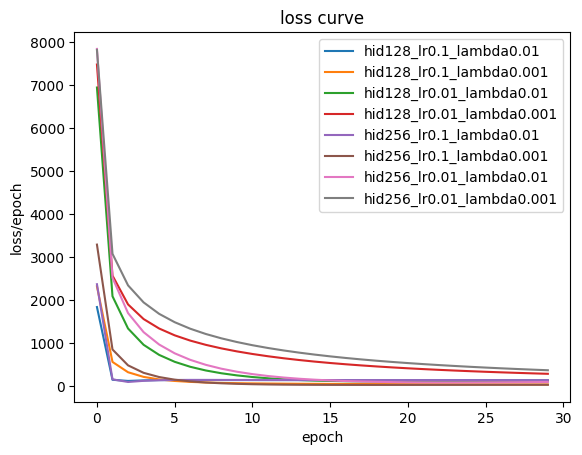

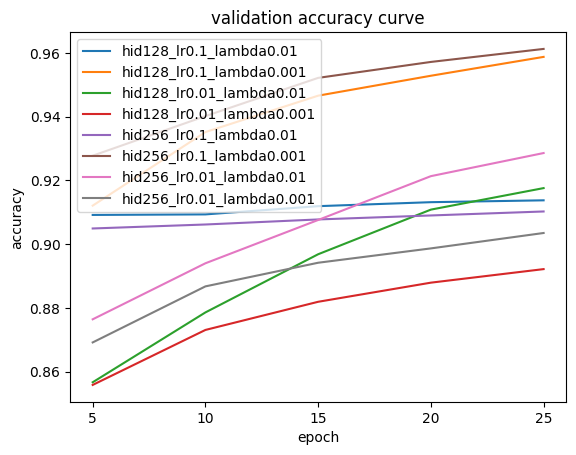

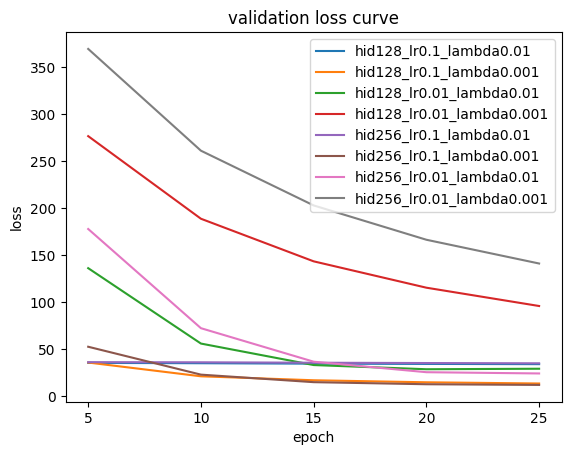

In [20]:
plt.figure(1)
for i, epoch_loss in enumerate(epoch_loss_tot):
    plt.plot(np.arange(len(epoch_loss)), epoch_loss, label=label_tot[i])
plt.xlabel("epoch")
plt.ylabel("loss/epoch")
plt.title("loss curve")
plt.legend(loc="best") 
plt.savefig("train_loss_curve.png", dpi=300)

plt.figure(2)
for i, epoch_valid_acc in enumerate(epoch_valid_acc_tot):
    plt.plot(valid_x, epoch_valid_acc, label=label_tot[i])
plt.xticks(valid_x, valid_x)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("validation accuracy curve")
plt.legend(loc="best") 
plt.savefig("acc_curve.png", dpi=300)

plt.figure(3)
for i, epoch_valid_loss in enumerate(epoch_valid_loss_tot):
    plt.plot(valid_x, epoch_valid_loss, label=label_tot[i])
plt.xticks(valid_x, valid_x)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("validation loss curve")
plt.legend(loc="best") 
plt.savefig("valid_loss_curve.png", dpi=300)
                    

In [21]:
def reduction_dimension(X):
    tsne = TSNE(n_components=2, random_state=0)
    X_tsne = tsne.fit_transform(X)
    return X_tsne

testing...
test acc: 0.9625


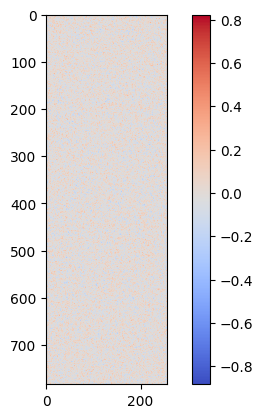

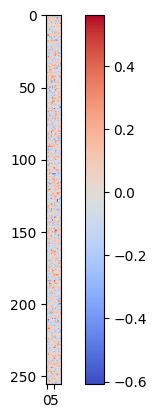

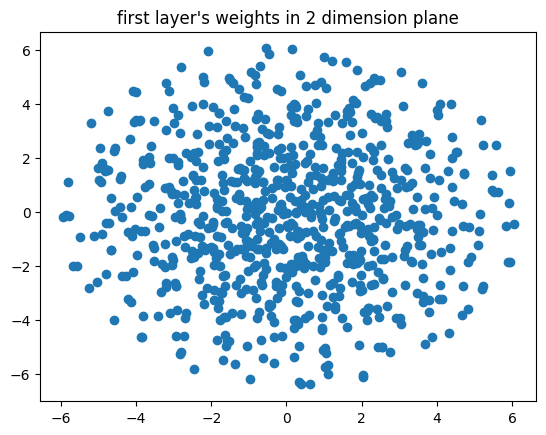

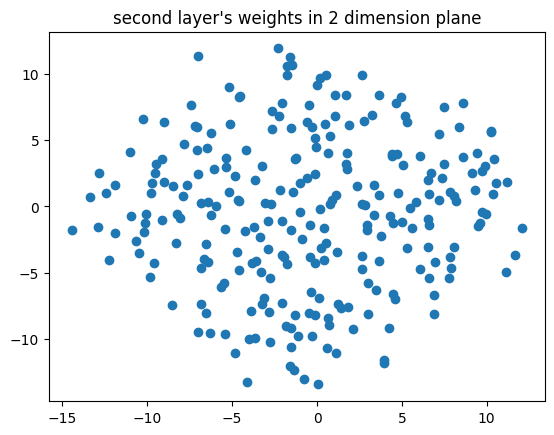

In [22]:
print("testing...")
test_model = Model(0, 0, 0)
test_model.load_model(f"./model_params/Model_hid{best_hidden_dim}_lr{best_lr}_lambda{best_lam}")
test_acc, _ = eval(test_dataloader, test_model)
print(f"test acc: {test_acc:.4f}")
plt.figure(1)
plt.imshow(test_model.layer1.W, cmap='coolwarm')
plt.colorbar()
plt.savefig("./parameter_visualize/layer1.png", dpi=300)
plt.figure(2)
plt.imshow(test_model.layer3.W, cmap='coolwarm')
plt.colorbar()
plt.savefig("./parameter_visualize/layer3.png", dpi=300)
layer1_reduction = reduction_dimension(test_model.layer1.W)
layer3_reduction = reduction_dimension(test_model.layer3.W)
plt.figure(3)
plt.scatter(layer1_reduction[:, 0], layer1_reduction[:, 1])
plt.title("first layer's weights in 2 dimension plane")
plt.savefig("./parameter_visualize/layer1_reduction.png", dpi=300)
plt.figure(4)
plt.scatter(layer3_reduction[:, 0], layer3_reduction[:, 1])
plt.title("second layer's weights in 2 dimension plane")
plt.savefig("./parameter_visualize/layer3_reduction.png", dpi=300)